In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rerun as rr
import genjax
import os
import numpy as np
import jax.numpy as jnp
import jax
from b3d import Pose
import b3d
from tqdm   import tqdm

PORT = 8812
rr.init("square_unprojection_test")
rr.connect(addr=f'127.0.0.1:{PORT}')

In [3]:
path = os.path.join(b3d.get_assets_path(),
#  "shared_data_bucket/input_data/orange_mug_pan_around_and_pickup.r3d.video_input.npz")
# "shared_data_bucket/input_data/shout_on_desk.r3d.video_input.npz")
"shared_data_bucket/input_data/desk_ramen2_spray1.r3d.video_input.npz")
video_input = b3d.VideoInput.load(path)

In [4]:
image_width, image_height, fx,fy, cx,cy,near,far = np.array(video_input.camera_intrinsics_depth)
image_width, image_height = int(image_width), int(image_height)
fx,fy, cx,cy,near,far = float(fx),float(fy), float(cx),float(cy),float(near),float(far)

rgbs = video_input.rgb[::3] / 255.0
xyzs = video_input.xyz[::3]
# Resize rgbs to be same size as depth.
rgbs_resized = jnp.clip(jax.vmap(jax.image.resize, in_axes=(0, None, None))(
    rgbs, (video_input.xyz.shape[1] // 8, video_input.xyz.shape[2] // 8, 3), "linear"
), 0.0, 1.0)
xyzs_resized = jax.vmap(jax.image.resize, in_axes=(0, None, None))(
    xyzs, (video_input.xyz.shape[1] // 8, video_input.xyz.shape[2] // 8, 3), "nearest"
)

point_cloud_og = xyzs_resized[0].reshape(-1,3)
colors_og = rgbs_resized[0].reshape(-1,3)

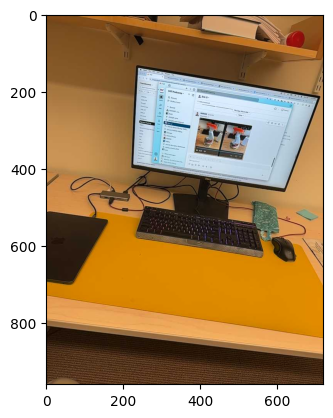

In [146]:
import matplotlib.pyplot as plt
plt.imshow(rgbs[0])

In [5]:
colors_og.shape

(768, 3)

In [6]:
point_cloud_og.shape

(768, 3)

In [7]:
rr.log(
    "points",
    rr.Points3D(
        point_cloud_og,
        colors=colors_og
    )
)

In [30]:
def point_to_square_mesh(pt, color, f, pixelwidth):
    x, y, z = pt[0], pt[1], pt[2]
    s = z / f * pixelwidth
    A = pt + 1/2 * jnp.array([-s, -s, 0])
    B = pt + 1/2 * jnp.array([ s, -s, 0])
    C = pt + 1/2 * jnp.array([ s,  s, 0])
    D = pt + 1/2 * jnp.array([-s,  s, 0])
    vertices = jnp.array([A, B, C, D])
    vertex_colors = jnp.array([color, color, color, color])
    faces = jnp.array([[0, 1, 2], [0, 2, 3]])
    return (vertices, faces, vertex_colors)

def all_square_meshes(pts, colors, f, pixelwidth):
    vertices_batched, faces_batched, colors_batched = jax.vmap(
        point_to_square_mesh, in_axes=(0, 0, None, None)
    )(pts, colors, f, pixelwidth)
    vertices = jnp.reshape(vertices_batched, (-1, 3))
    colors = jnp.reshape(colors_batched, (-1, 3))
    faces_relabeled = jnp.reshape(faces_batched + jnp.arange(pts.shape[0]).reshape(-1, 1, 1) * 4, (-1, 3))
    faces = jnp.array(faces_relabeled)
    return (vertices, faces, colors)

In [36]:
f = fx
pixelwidth = 2.0 * 8.0
vertices, faces, colors = all_square_meshes(point_cloud_og, colors_og, f, pixelwidth)

In [67]:
rr.log(
    f"/squares",
    rr.Mesh3D(
        vertex_positions=vertices,
        indices=faces,
        vertex_colors=colors
    ),
    time=0.0
)

/var/tmp/ipykernel_15755/3377109699.py:1: RerunWarning: log: TypeError(log() got an unexpected keyword argument 'time')
  rr.log(


In [90]:
def get_vertices_to_merge(vertices):
    pairwise_distance_matrix = jnp.sqrt(jnp.sum((vertices[:, None] - vertices[None]) ** 2, axis=-1))
    
    def face_to_share_face_matrix(f):
        M = jnp.zeros((vertices.shape[0], vertices.shape[0]))
        M.at[f, f].set(1)
        # for i in range(4):
        #     for j in range(4):
        #         M = M.at[f[i], f[j]].set(1)
        return M

    # sum over all faces without vmapping, using jax.lax.while
    share_face_matrix = jnp.zeros((vertices.shape[0], vertices.shape[0]))
    share_face_matrix = jax.lax.fori_loop(
        0, faces.shape[0],
        lambda i, share_face_matrix: share_face_matrix + face_to_share_face_matrix(faces[i]),
        share_face_matrix
    )

    share_face_matrix_with_infs = jnp.where(share_face_matrix > 0, jnp.inf, 0.)
    distances = pairwise_distance_matrix + share_face_matrix_with_infs
    distances = jnp.where(distances > 0, distances, jnp.inf)
    min_indices = jnp.unravel_index(jnp.argmin(distances), distances.shape)
    return min_indices

In [133]:
def merge_indices(vertices, faces, colors, i, j):
    new_vertex = (vertices[i] + vertices[j]) / 2
    new_color = (colors[i] + colors[j]) / 2
    v2 = vertices.at[i].set(new_vertex)
    v2 = v2.at[j].set(jnp.zeros(3))
    c2 = colors.at[i].set(new_color)
    c2 = c2.at[j].set(jnp.zeros(3))
    f2 = jnp.where(faces == j, i, faces)
    return (v2, f2, c2)

In [134]:
@jax.jit
def merge_nearest(vertices, faces, colors):
    indices = get_vertices_to_merge(vertices)
    i, j = indices
    vertices, faces, colors = merge_indices(vertices, faces, colors, i, j)
    return (vertices, faces, colors)

In [141]:
v, f, c = vertices, faces, colors
for t in range(4000):
    v, f, c = merge_nearest(v, f, c)
    rr.set_time_sequence("mergestep", t)
    rr.log(
        f"/squares",
        rr.Mesh3D(
            vertex_positions=v,
            indices=f,
            vertex_colors=c
        )
    )

In [54]:
share_face_matrix_with_infs = jnp.where(share_face_matrix > 0, jnp.inf, 0.)

In [56]:
distances_with_inf_if_share_face = pairwise_distance_matrix + share_face_matrix_with_infs

In [64]:
# get indices (i, j) of the smallest distances
min_indices = jnp.unravel_index(jnp.argmin(distances_with_inf_if_share_face), distances_with_inf_if_share_face.shape)
min_indices

(Array(537, dtype=int32), Array(544, dtype=int32))

In [66]:
(v2, _, _) = merge_indices(vertices, faces, colors, min_indices[0], min_indices[1])